## Setup

### Importing Dependencies

In [1]:
# Torch for training models
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

from transformers import GPT2Tokenizer, GPT2LMHeadModel # For obtaining GPT-2 embeddings

# Data loading / Utilities
import os
import pickle
from functools import partial

# Transformer model class
from transformer_model import TransformerModel

# Submodel classes
from sub_models import EmbeddingModel, AttentionModel

# Tuned Lens model dataset
from lens_dataset import TunedLensDataset, lens_collate_fn

# Tuned Lens model class
from tuned_lens import TunedLens

# Loss function for training the Tuned Lens
from utils import kl_loss

### Fixing Random Seeds for Reproducibility

In [2]:
seed = 42
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

### Defining Project Directories

In [3]:
proj_dir = "./QLens/" # Personalize if needed

data_dir = proj_dir + "Datasets/"

model_dir = proj_dir + "Model_Checkpoints/"
lens_dir = proj_dir + "Lens_Checkpoints/"

## Loading Sentihood Data

In [4]:
# Loading saved Train and Test splits

train_path = data_dir + 'train.pickle'
test_path = data_dir + 'test.pickle'

with open(train_path, 'rb') as train_file:
    train_dict = pickle.load(train_file)

with open(test_path, 'rb') as test_file:
    test_dict = pickle.load(test_file)

In [5]:
# Resolving train and test splits into input/output segments

X_train = train_dict['X']
y_train = train_dict['y']

X_test = test_dict['X']
y_test = test_dict['y']

## Loading Base Transformer Model

In [6]:
# Instantiating the Transfomer model's architecture

# Selecting the training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GPT-2 Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': '<PAD>', 'cls_token': '<CLS>'})

# Hyperparameters
d_embedding = 768   # Dimensionality of initial GPT-2 embeddings
d_model = 128       # Dimension of the model's feature space
num_heads = 4       # Number of attention heads
d_ff = 512          # Dimension of the inner MLP layer
dropout_rate = 0.1  # Dropout rate

model = TransformerModel(d_embedding = d_embedding,
                         d_model = d_model,
                         dim_feedforward = d_ff,
                         num_heads = num_heads,
                         dropout_rate = dropout_rate,
                         tokenizer_len = len(tokenizer))
model.to(device)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


TransformerModel(
  (word_embeddings_layer): Embedding(50259, 768)
  (positional_embeddings_layer): Embedding(1024, 768)
  (compression): Linear(in_features=768, out_features=128, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (w1): Linear(in_features=128, out_features=512, bias=True)
  (attention_dropout): Dropout(p=0.1, inplace=False)
  (w2): Linear(in_features=512, out_features=128, bias=True)
  (attention_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (mlp_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (w1_dropout): Dropout(p=0.1, inplace=False)
  (w2_dropout): Dropout(p=0.1, inplace=False)
  (classification_layer): Linear(in_features=128, out_features=2, bias=True)
)

In [7]:
# Loading model state dict
model_checkpoint = torch.load(os.path.join(model_dir, 'model_checkpoint.pth'))
model_state_dict = model_checkpoint['model_state_dict']

model.load_state_dict(model_state_dict)
model.to(device)

TransformerModel(
  (word_embeddings_layer): Embedding(50259, 768)
  (positional_embeddings_layer): Embedding(1024, 768)
  (compression): Linear(in_features=768, out_features=128, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (w1): Linear(in_features=128, out_features=512, bias=True)
  (attention_dropout): Dropout(p=0.1, inplace=False)
  (w2): Linear(in_features=512, out_features=128, bias=True)
  (attention_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (mlp_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (w1_dropout): Dropout(p=0.1, inplace=False)
  (w2_dropout): Dropout(p=0.1, inplace=False)
  (classification_layer): Linear(in_features=128, out_features=2, bias=True)
)

## Preparing the Embedding Lens

In [8]:
# Training tuned lens for intermediate classifcation after the embedding layer
embedding_lens = TunedLens(d_model, model.mlp_norm, model.classification_layer, 'embedding').to(device)
embedding_model = EmbeddingModel(model.compression, device)

# Hyperparameters
batch_size = 4
num_epochs = 5

# Creating an instance of the TunedLensDataset
embedding_train = TunedLensDataset(X_train, tokenizer, embedding_model, model, device)

# Creating a DataLoader object for training
embedding_train_dataloader = DataLoader(embedding_train, batch_size = batch_size, collate_fn = lens_collate_fn, shuffle=True)

# Defining loss function, optimizer, and learning rate scheduler
embedding_lens_criterion = kl_loss
embedding_lens_optimizer = optim.Adam(embedding_lens.parameters(), lr=0.001)
embedding_scheduler = OneCycleLR(embedding_lens_optimizer,
                       max_lr=1e-2,
                       steps_per_epoch=len(embedding_train_dataloader),
                       epochs=num_epochs,
                       pct_start=0.3)

Starting training loop...


Epoch 1/5: 100%|██████████| 214/214 [00:11<00:00, 18.49it/s]


Epoch [1/5], Average Loss: 0.2849, Learning Rate: 0.0076


Epoch 2/5: 100%|██████████| 214/214 [00:11<00:00, 18.77it/s]


Epoch [2/5], Average Loss: 0.2300, Learning Rate: 0.0095


Epoch 3/5: 100%|██████████| 214/214 [00:11<00:00, 18.87it/s]


Epoch [3/5], Average Loss: 0.2296, Learning Rate: 0.0061


Epoch 4/5: 100%|██████████| 214/214 [00:11<00:00, 18.83it/s]


Epoch [4/5], Average Loss: 0.2293, Learning Rate: 0.0019


Epoch 5/5: 100%|██████████| 214/214 [00:11<00:00, 18.89it/s]


Epoch [5/5], Average Loss: 0.2289, Learning Rate: 0.0000
Training finished!
Checkpoint for Epoch 5 saved to ./QLens/Lens_Checkpoints/embedding_lens_checkpoint.pth


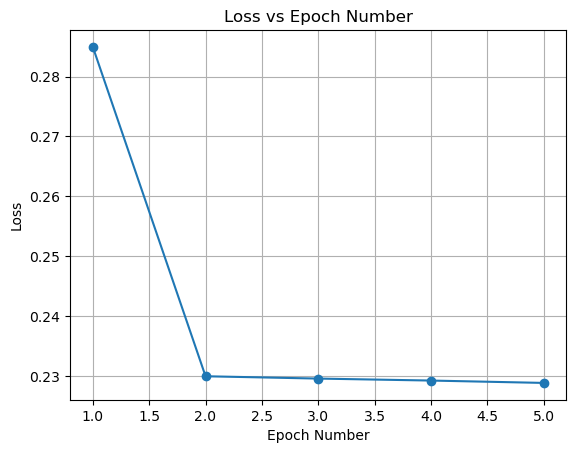

In [9]:
# Training
embedding_train_losses = embedding_lens.train_model(
    train_dataloader = embedding_train_dataloader,
    criterion = embedding_lens_criterion,
    optimizer = embedding_lens_optimizer,
    num_epochs = num_epochs,
    device = device,
    lens_dir = lens_dir,
    scheduler = embedding_scheduler
)

In [10]:
# Evaluation Dataset and Dataloader
embedding_test = TunedLensDataset(X_test, tokenizer, embedding_model, model, device)
embedding_test_dataloader = DataLoader(embedding_test, batch_size=batch_size, collate_fn = lens_collate_fn)

# Conducting Evaluation
embedding_test_results = embedding_lens.evaluate_model(
    test_dataloader = embedding_test_dataloader,
    criterion = embedding_lens_criterion,
    device = device
)

Embedding Lens Evaluation: 100%|██████████| 54/54 [00:00<00:00, 185.76it/s]


Test Loss: 0.2100, Accuracy against base model: 0.8458
Test complete!


## Preparing the Attention Lens

In [11]:
# Training tuned lens for intermediate classifcation after the embedding layer
attention_lens = TunedLens(d_model, model.mlp_norm, model.classification_layer, 'attention').to(device)
attention_model = AttentionModel(model.compression, model.attention, device)

# Hyperparameters
batch_size = 4
num_epochs = 5

# Creating instances of custom dataset
attention_train = TunedLensDataset(X_train, tokenizer, attention_model, model, device)

# Creating DataLoader objects for batching
attention_train_dataloader = DataLoader(attention_train, batch_size = batch_size, collate_fn = lens_collate_fn, shuffle=True)

# Defining loss function and optimizer
attention_lens_criterion = kl_loss
attention_lens_optimizer = optim.Adam(attention_lens.parameters(), lr=0.001)
attention_scheduler = OneCycleLR(attention_lens_optimizer,
                       max_lr=1e-2,
                       steps_per_epoch=len(attention_train_dataloader),
                       epochs=num_epochs,
                       pct_start=0.3)

Starting training loop...


Epoch 1/5: 100%|██████████| 214/214 [00:12<00:00, 17.17it/s]


Epoch [1/5], Average Loss: 0.0178, Learning Rate: 0.0076


Epoch 2/5: 100%|██████████| 214/214 [00:12<00:00, 17.22it/s]


Epoch [2/5], Average Loss: 0.0169, Learning Rate: 0.0095


Epoch 3/5: 100%|██████████| 214/214 [00:12<00:00, 17.18it/s]


Epoch [3/5], Average Loss: 0.0165, Learning Rate: 0.0061


Epoch 4/5: 100%|██████████| 214/214 [00:12<00:00, 17.32it/s]


Epoch [4/5], Average Loss: 0.0159, Learning Rate: 0.0019


Epoch 5/5: 100%|██████████| 214/214 [00:12<00:00, 17.35it/s]


Epoch [5/5], Average Loss: 0.0141, Learning Rate: 0.0000
Training finished!
Checkpoint for Epoch 5 saved to ./QLens/Lens_Checkpoints/attention_lens_checkpoint.pth


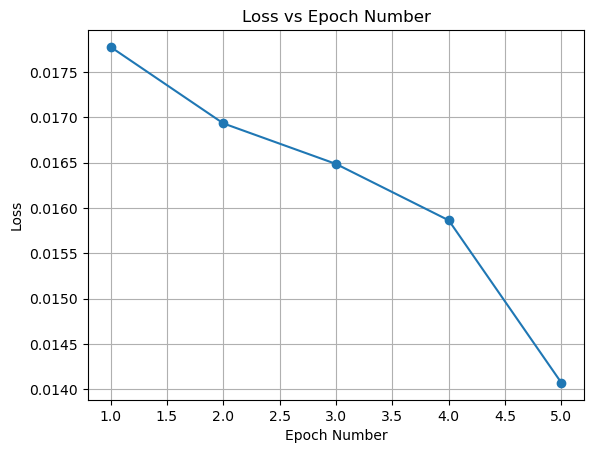

In [12]:
# Training
attention_train_losses = attention_lens.train_model(
    train_dataloader = attention_train_dataloader,
    criterion = attention_lens_criterion,
    optimizer = attention_lens_optimizer,
    num_epochs = num_epochs,
    device = device,
    lens_dir = lens_dir,
    scheduler = attention_scheduler
)

In [13]:
# Evaluation Dataset and Dataloader
attention_test = TunedLensDataset(X_test, tokenizer, attention_model, model, device)
attention_test_dataloader = DataLoader(attention_test, batch_size = batch_size, collate_fn = lens_collate_fn)

# Conducting Evaluation
attention_test_results = attention_lens.evaluate_model(
    test_dataloader = attention_train_dataloader,
    criterion = attention_lens_criterion,
    device = device
)

Attention Lens Evaluation: 100%|██████████| 214/214 [00:01<00:00, 157.25it/s]


Test Loss: 0.0144, Accuracy against base model: 0.9720
Test complete!
